In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### **Dataset**

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv

--2025-10-07 21:02:26--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: 'car_fuel_efficiency.csv'

     0K .......... .......... .......... .......... ..........  5% 1.26M 1s
    50K .......... .......... .......... .......... .......... 11% 1.88M 0s
   100K .......... .......... .......... .......... .......... 17% 2.71M 0s
   150K .......... .......... .......... .......... .......... 23% 2.49M 0s
   200K .......... .......... .......... .......... .......... 29% 2.03M 0s
   250K .......... .......... .......... .......... .......... 35% 2.44M 0s
   300K .......... .......... .......... .......... .......... 40% 2.16M 0s
   350K .

### **Preparing the Dataset**

In [8]:
df = pd.read_csv('car_fuel_efficiency.csv',
            usecols=['engine_displacement', 'horsepower',
                     'vehicle_weight', 'model_year', 'fuel_efficiency_mpg'])
df.head()

,engine_displacement,horsepower,vehicle_weight,model_year,fuel_efficiency_mpg
0,170,159.0,3413.433759,2003,13.231729
1,130,97.0,3149.664934,2007,13.688217
2,170,78.0,3079.038997,2018,14.246341
3,220,NaN,2542.392402,2009,16.912736
4,210,140.0,3460.870990,2009,12.488369


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9704 entries, 0 to 9703
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   engine_displacement  9704 non-null   int64  
 1   horsepower           8996 non-null   float64
 2   vehicle_weight       9704 non-null   float64
 3   model_year           9704 non-null   int64  
 4   fuel_efficiency_mpg  9704 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 379.2 KB


### **EDA**

<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

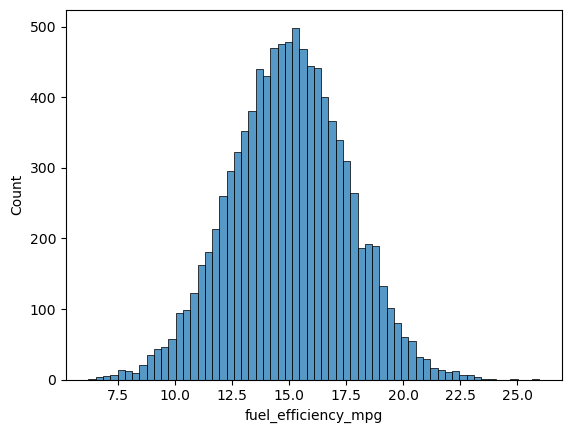

In [11]:
sns.histplot(data=df, x='fuel_efficiency_mpg')

### **Question 1**
There's one column with missing values. What is it?

In [12]:
missing_columns = df.columns[df.isnull().any()][0]
print(f"{missing_columns} column has missing values")

horsepower column has missing values


### **Question 2**
What's the median (50% percentile) for variable 'horsepower'

In [15]:
median_horsepower = np.median(df['horsepower'].dropna())
print(f"The median of horsepower variable is {median_horsepower}")

The median of horsepower variable is 149.0


### **Prepare and split the dataset**
- Shuffle the dataset (the filtered one you created above), use seed 42.
- Split your data in train/val/test sets, with 60%/20%/20% distribution

In [16]:
n = df.shape[0]
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

assert n == n_train + n_val + n_test

In [17]:
idx = np.arange(n)

np.random.seed(42)
np.random.shuffle(idx)

In [18]:
df_train = df.iloc[idx[:n_train]].reset_index(drop=False)
df_val = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=False)
df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop=False)

assert df.shape[0] == df_train.shape[0] + df_val.shape[0] + df_test.shape[0]

### **Question 3**
- We need to deal with missing values for the column from Q1.
- We have two options: fill it with 0 or with the mean of this variable.
- Try both options. For each, train a linear regression model without regularization using the code from the lessons.
- For computing the mean, use the training only!
- Use the validation dataset to evaluate the models and compare the RMSE of each option.
- Round the RMSE scores to 2 decimal digits using round(score, 2)
- Which option gives better RMSE?

In [19]:
mean_horsepower = df_train['horsepower'].mean()

def prepare_X(df, impute_na=0):
    df = df.copy()
    df['horsepower'] = df['horsepower'].fillna(impute_na)
    X = df.iloc[:, :-1].values

    return X

X_train_zero = prepare_X(df_train)
X_train_mean = prepare_X(df_train, impute_na=mean_horsepower)
y_train = df_train.iloc[:, -1].values

X_val_zero = prepare_X(df_val)
X_val_mean = prepare_X(df_val, impute_na=mean_horsepower)
y_val = df_val.iloc[:, -1].values

X_test_zero = prepare_X(df_test)
X_test_mean = prepare_X(df_test, impute_na=mean_horsepower)
y_test = df_test.iloc[:, -1].values

In [20]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    se = (y - y_pred) ** 2
    mse = se.mean()
    rmse = round(np.sqrt(mse), 2)
    return rmse

In [21]:
w0, w = train_linear_regression(X_train_zero, y_train)
y_pred_zero = w0 + X_val_zero.dot(w)
rmse_zero = rmse(y_val, y_pred_zero)

print(f"RMSE for model with imputed null value with zero values: {rmse_zero}")

RMSE for model with imputed null value with zero values: 0.52


In [22]:
w0, w = train_linear_regression(X_train_mean, y_train)
y_pred_mean = w0 + X_val_mean.dot(w)
rmse_mean = rmse(y_val, y_pred_mean)

print(f"RMSE for model with imputed null value with mean of training value: {rmse_mean}")

RMSE for model with imputed null value with mean of training value: 0.46


Option with imputed mean gives better RMSE

### **Question 4**
- Now let's train a regularized linear regression.
- For this question, fill the NAs with 0.
- Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
- Use RMSE to evaluate the model on the validation dataset.
- Round the RMSE scores to 2 decimal digits.
- Which r gives the best RMSE?

In [23]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [24]:
rmse_scores = {}
list_r = [0, 0.01, 0.1, 1, 5, 10, 100]

for r in list_r:
    w0, w = train_linear_regression_reg(X_train_zero, y_train, r)
    y_pred_zero = w0 + X_val_zero.dot(w)
    rmse_zero = rmse(y_val, y_pred_zero)
    rmse_scores[r] = rmse_zero

best_r = min(rmse_scores.items(), key=lambda k: k[1])[0]
print(f"Best r value based on the minimum RMSE: {best_r}")

Best r value based on the minimum RMSE: 0


### **Question 5**
- We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
- Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
- For each seed, do the train/validation/test split with 60%/20%/20% distribution.
- Fill the missing values with 0 and train a model without regularization.
- For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
- What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
- Round the result to 3 decimal digits (round(std, 3))

What's the value of std?

In [25]:
seed_values = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmse_scores = []

for s in seed_values:
    idx = np.arange(n)
    np.random.seed(s)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]].reset_index(drop=False)
    df_val = df.iloc[idx[n_train:n_train+n_val]].reset_index(drop=False)
    df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop=False)

    X_train_zero = prepare_X(df_train)
    y_train = df_train.iloc[:, -1].values

    X_val_zero = prepare_X(df_val)
    y_val = df_val.iloc[:, -1].values

    X_test_zero = prepare_X(df_test)
    y_test = df_test.iloc[:, -1]
    
    w0, w = train_linear_regression(X_train_zero, y_train)
    y_pred_zero = w0 + X_val_zero.dot(w)
    rmse_zero = rmse(y_val, y_pred_zero)

    rmse_scores.append(rmse_zero)

std_rmse = round(np.std(rmse_scores), 3)
print(f"The standard deviation across RMSE scores: {std_rmse}")

The standard deviation across RMSE scores: 0.007


### **Question 6**
- Split the dataset like previously, use seed 9.
- Combine train and validation datasets.
- Fill the missing values with 0 and train a model with r=0.001.
- What's the RMSE on the test dataset?

In [26]:
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

df_full_train = df.iloc[idx[:n_train+n_val]].reset_index(drop=False)
df_test = df.iloc[idx[n_train+n_val:]].reset_index(drop=False)

X_train = prepare_X(df_full_train)
y_train = df_full_train.iloc[:, -1].values

X_test = prepare_X(df_test)
y_test = df_test.iloc[:, -1].values

w0, w = train_linear_regression_reg(X_train, y_train, r=0.001)
y_pred = w0 + X_test.dot(w)
rmse_model = rmse(y_test, y_pred)


print(f"The RMSE of the model: {rmse_model}")

The RMSE of the model: 0.52
